# Import Libraries

In [1]:
import random 
import os 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import regularizers
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Reshape
from keras.callbacks import ModelCheckpoint
from keras.applications import MobileNet, VGG16, VGG19
from keras.models import Model
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths

In [3]:
TRAIN_PATH = 'Dataset/Train'
TEST_PATH = 'Dataset/Test'
CATEGORIES = ['Fire', 'NoFire']

# Training Classes Path
TRAINING_FIRE_DIR = os.path.join(TRAIN_PATH, "Fire")
TRAINING_NoFire_DIR = os.path.join(TRAIN_PATH, "NoFire")

#Testing Classes Path
TEST_FIRE_DIR = os.path.join(TEST_PATH, "Fire")
TEST_NoFire_DIR = os.path.join(TEST_PATH, "NoFire")

## Review Dataset Sample

In [4]:
# Training and validation splits. Check that the number of images matches the expected output.
print(f"Total Train {len(os.listdir(TRAINING_FIRE_DIR)) + len(os.listdir(TRAINING_NoFire_DIR))} images")
print(f"Total Test {len(os.listdir(TEST_FIRE_DIR)) + len(os.listdir(TEST_NoFire_DIR))} images\n")

print(f"Train->Fire {len(os.listdir(TRAINING_FIRE_DIR))} images")
print(f"Train->NoFire {len(os.listdir(TRAINING_NoFire_DIR))} images\n")
print(f"Test->Fire {len(os.listdir(TEST_FIRE_DIR))} images of")
print(f"Test->NoFire {len(os.listdir(TEST_NoFire_DIR))} images")

Total Train 2425 images
Total Test 871 images

Train->Fire 1124 images
Train->NoFire 1301 images

Test->Fire 593 images of
Test->NoFire 278 images


# PLot Sample Image

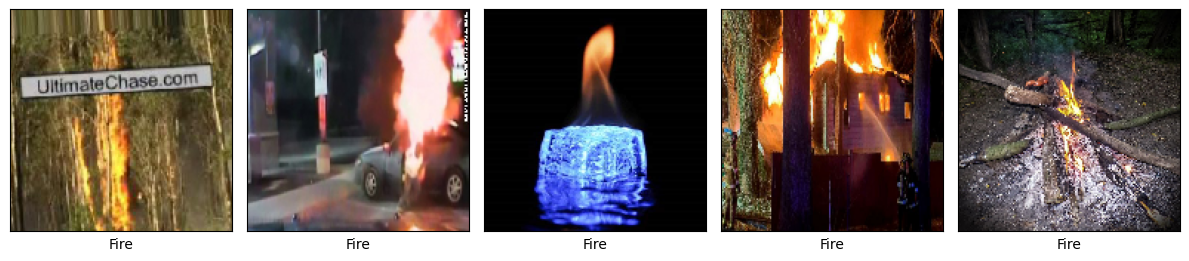

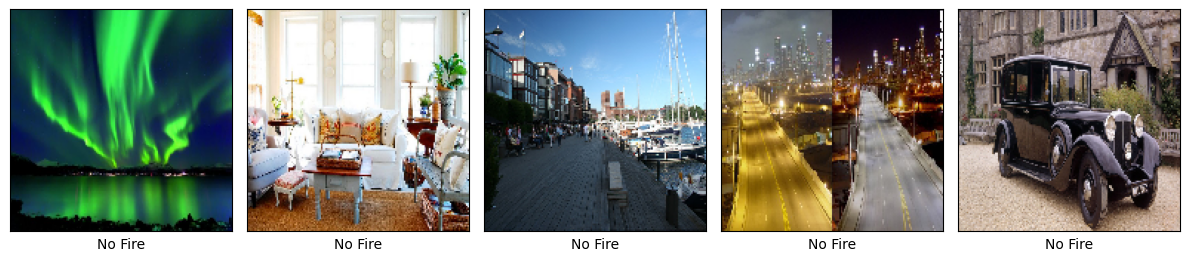

In [8]:
import random
from tensorflow.keras.preprocessing.image import load_img

fire = random.sample(os.listdir(TRAINING_FIRE_DIR),5)
no_fire = random.sample(os.listdir(TRAINING_NoFire_DIR),5)

plt.figure(figsize=(12,7))
for i,img in enumerate(fire):
    path = os.path.join(TRAINING_FIRE_DIR,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Fire")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

plt.figure(figsize=(12,7))
for i,img in enumerate(no_fire):
    path = os.path.join(TRAINING_NoFire_DIR,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("No Fire")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

# Prepare Dataset

In [9]:
IMG_SIZE = 128 #images will be resized to a square shape with dimensions 64x64 pixels

def create_training_data(PATH):
    training_data = [] # Initialize an empty list to store the training data
    for category in CATEGORIES:
        path = os.path.join(PATH, category) # Construct the path to the category's directory
        class_num = CATEGORIES.index(category) # Get the class index for the current category

        for img in tqdm(os.listdir(path)):
            try:
                raw_img = cv2.imread(os.path.join(path, img)) # Read the image using OpenCV's imread function
                resized_img = cv2.resize(raw_img, (IMG_SIZE, IMG_SIZE)) # Resize the image to a specified size
                training_data.append([resized_img, class_num]) # Append the resized image and its class index to the training data list
            except Exception as e:
                pass
    print(f'There are {len(training_data)} items.')
    return training_data

training_data = create_training_data(TRAIN_PATH) # Create the training data using the create_training_data function
np.random.shuffle(training_data)  # Shuffle the training data

X = []  # Initialize an empty list to store the features (input data)
Y = [] # Initialize an empty list to store the labels (output data)

for features, label in training_data:
    X.append(features) # Append the features (input data) to the X list
    Y.append(label) # Append the label (output data) to the Y list

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3) # to Convert the X list to a NumPy array and reshape it to match the desired input shape
X = X / 255.0 # to Normalize the pixel values in X by dividing them by 255.0 (scaling them between 0 and 1)
Y = np.array(Y)  # for Converting the Y list to a NumPy array


X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42) # Split the data into training and validation sets

100%|██████████| 1301/1301 [00:07<00:00, 171.27it/s]


There are 2423 items.


## Simple Model

In [5]:
# model = Sequential() 
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3, 3))) 
# model.add(Dropout(0.25))
# 
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3, 3))) 
# model.add(Dropout(0.25))
# 
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3, 3))) 
# model.add(Dropout(0.25))
# 
# # model.add(Flatten()) 
# model.add(GlobalAveragePooling2D())
# 
# model.add(Dense(64, activation='relu'))  
# model.add(Dropout(0.25)) 
# 
# model.add(Dense(32, activation='softmax')) 
# 
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
# 
# 
# # Summary of the model
# model.summary()

## Depth-wise Seperable Convolution

In [10]:
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras import regularizers

# Load pre-trained MobileNet without the top (classification) layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Fine-tune only the last few layers of the base model
fine_tune_layers = 2
for layer in base_model.layers[:-fine_tune_layers]:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Summary of the model
model.summary()


2024-06-06 18:22:18.396859: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-06 18:22:18.397393: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-06 18:22:18.397405: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-06 18:22:18.398659: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-06 18:22:18.399232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                32800     
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                        

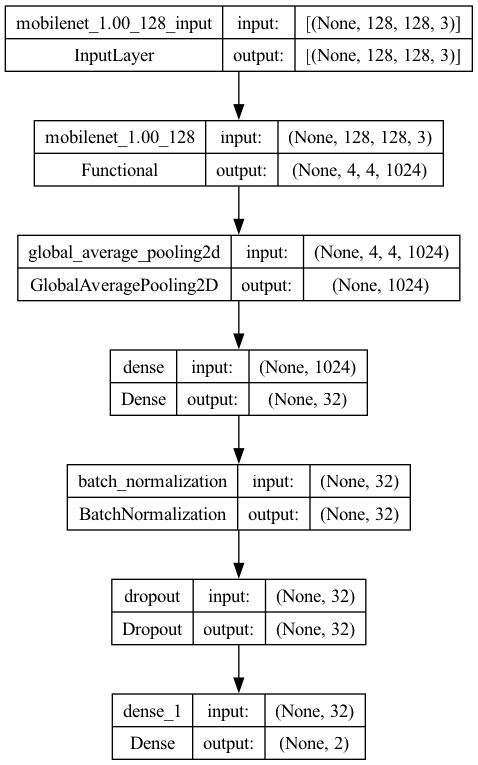

In [11]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Train Model

In [12]:
filepath = 'Dataset/TrainedModel/model-FireNetv3.0-{epoch:02d}-performance-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'

checkpoint_acc = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks = [checkpoint_acc, checkpoint_loss]

epochs = 75

history = model.fit(X_train, Y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(X_val, Y_val),
                    callbacks=callbacks,
                    verbose=0)

2024-06-06 18:25:27.333078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-06 18:25:36.645276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.95062, saving model to Dataset/TrainedModel/model-FireNetv3.0-01-performance-0.95-0.22.hdf5

Epoch 1: val_loss improved from inf to 0.22396, saving model to Dataset/TrainedModel/model-FireNetv3.0-01-performance-0.95-0.22.hdf5

Epoch 2: val_accuracy improved from 0.95062 to 0.97531, saving model to Dataset/TrainedModel/model-FireNetv3.0-02-performance-0.98-0.16.hdf5

Epoch 2: val_loss improved from 0.22396 to 0.15509, saving model to Dataset/TrainedModel/model-FireNetv3.0-02-performance-0.98-0.16.hdf5

Epoch 3: val_accuracy did not improve from 0.97531

Epoch 3: val_loss improved from 0.15509 to 0.13892, saving model to Dataset/TrainedModel/model-FireNetv3.0-03-performance-0.98-0.14.hdf5

Epoch 4: val_accuracy improved from 0.97531 to 0.97942, saving model to Dataset/TrainedModel/model-FireNetv3.0-04-performance-0.98-0.12.hdf5

Epoch 4: val_loss improved from 0.13892 to 0.12488, saving model to Dataset/TrainedModel/model-FireNetv3.0-04-perf

## Plot Results

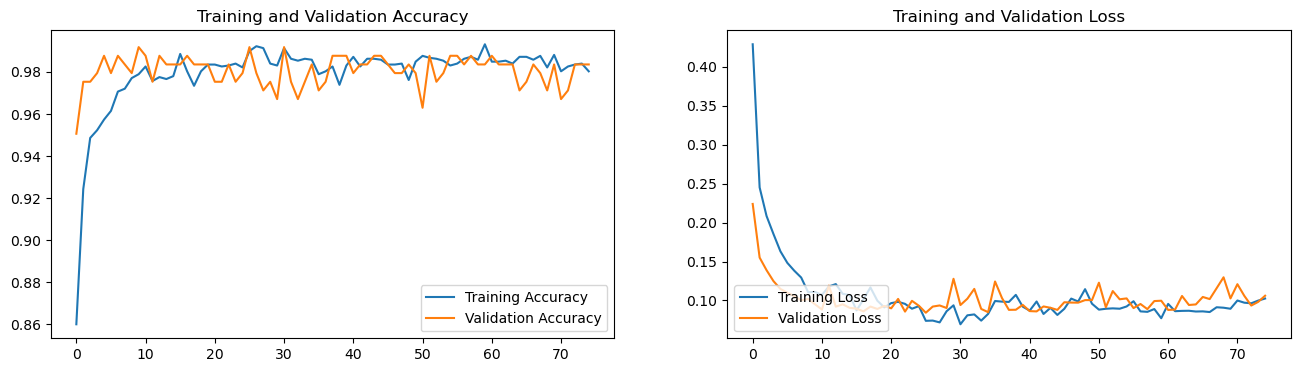

In [15]:
import matplotlib.pyplot as plt # Import the matplotlib.pyplot module for plotting graph

epochs_range = range(epochs)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

# Performance Evaluation

## Load Model

In [16]:
from tensorflow.keras.models import load_model

best_model = load_model('Dataset/TrainedModel/model-FireNetv3.0-26-performance-0.99-0.08.hdf5')

## Evaluate Model

In [17]:
new_records = best_model.evaluate(X_val, Y_val)

2024-06-06 18:31:42.653282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 67ms/step - loss: 0.0843 - accuracy: 0.9918


## Performance Analysis

In [18]:
import tensorflow as tf


predictions = best_model.predict(X_val) # predict output for all test data

scores = tf.nn.softmax(predictions)
Y_pred = []
for score in scores:
    Y_pred.append(np.argmax(score))
Y_pred = np.array(Y_pred) # predicted labels
Y_true = Y_val # true labels

2024-06-06 18:31:54.969628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 56ms/step


## Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix

# Defining function for confusion matrix plot
def plot_confusion_matrix(Y_true, Y_pred, Classes, normalize=False, title=None, cmap=plt.cm.Blues):

    # Compute the confusion matrix
    conf_mat = confusion_matrix(Y_true, Y_pred)
    if normalize:
        conf_mat = conf_mat.astype('float32') / conf_mat.sum(axis=1)[:, np.newaxis]
        print(title)
    else:
        print(title)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]), yticks=np.arange(conf_mat.shape[0]),
           xticklabels=Classes, yticklabels=Classes,
           title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

np.set_printoptions(precision=2)

### Not Normalized

None


<Axes: xlabel='Predicted label', ylabel='True label'>

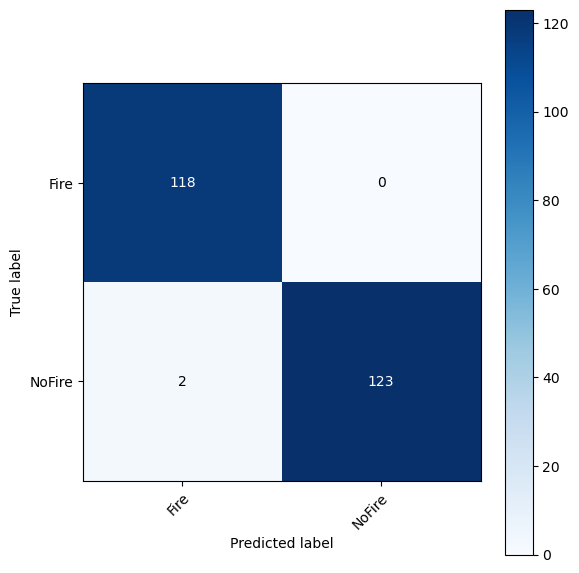

In [20]:
from sklearn.metrics import confusion_matrix

#Plotting the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, Classes = CATEGORIES)

### Normalized

None


<Axes: xlabel='Predicted label', ylabel='True label'>

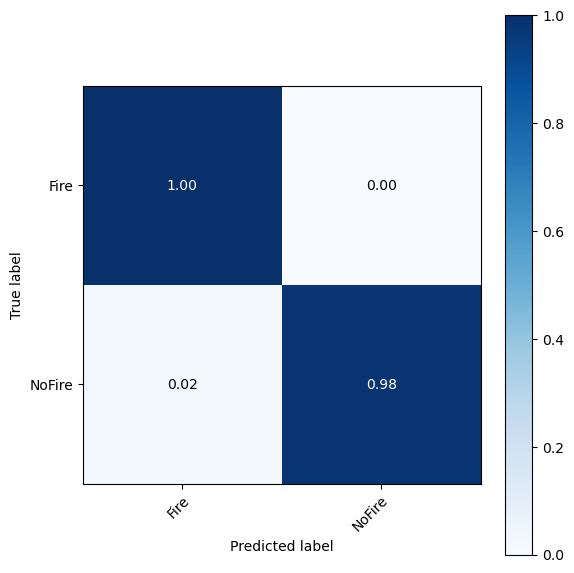

In [21]:
#Plotting normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, Classes = CATEGORIES, normalize = True)

## Performance Metrics

In [22]:
from sklearn import metrics

def get_metrics(true_labels, predicted_labels):
    print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
    print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
    print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))

get_metrics(Y_true, Y_pred)

def display_classification_report(true_labels, predicted_labels, Classes):
    report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=Classes)
    print("\nReport:\n"+report)

display_classification_report(Y_true, Y_pred, CATEGORIES)

Accuracy: 0.9918
Precision: 0.9919
Recall: 0.9918
F1 Score: 0.9918

Report:
              precision    recall  f1-score   support

        Fire       0.98      1.00      0.99       118
      NoFire       1.00      0.98      0.99       125

    accuracy                           0.99       243
   macro avg       0.99      0.99      0.99       243
weighted avg       0.99      0.99      0.99       243



# Test Model Using Test Set

## Load Test Set

In [23]:
testing_data = create_training_data(TEST_PATH)  # Call the function create_training_data() to obtain the training data
np.random.shuffle(testing_data)

print(len(testing_data))

100%|██████████| 278/278 [00:01<00:00, 168.48it/s]

There are 871 items.
871


## Prepare Test Set

In [24]:
X = []  # Initialize an empty list to store the features (input data)
Y = [] # Initialize an empty list to store the labels (output data)

for features, label in testing_data:
    X.append(features) # Append the features (input data) to the X list
    Y.append(label) # Append the label (output data) to the Y list

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3) # to Convert the X list to a NumPy array and reshape it to match the desired input shape
X = X / 255.0 # to Normalize the pixel values in X by dividing them by 255.0 (scaling them between 0 and 1)
Y = np.array(Y)  # for Converting the Y list to a NumPy array

In [25]:
test_image_num = 871  # Set the number of test images
test_labels=np.zeros((test_image_num,1))

c=0 # Initialize the counter variable c to 0
for sample in testing_data:
    test_labels[c]=(sample[1]) # Assign the label of the current sample to the corresponding index in test_labels
    c+=1 # Increment the counter c by 1 after processing each sample
print(c) # Print the value of c, which represents the number of samples
actual_labels=(test_labels.reshape(test_image_num,)) # Reshape test_labels to a 1-dimensional array
print(actual_labels.shape) # Print the shape of actual_labels
actual_labels.astype(int) # Convert the data type of actual_labels to integer

X = [] # Create an empty list to store the features
Y = [] # Create an empty list to store the labels

for features, label in testing_data:
    X.append(features) # Append the features of each sample to the X list
    Y.append(label) # Append the label of each sample to the Y list

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3) # Convert X to a NumPy array and reshape it to the desired dimensions
X = X / 255.0 # Normalize the pixel values of X by dividing by 255.0


871
(871,)


## Evaluation on Test Set

In [26]:
predicted_probabilities = best_model.predict(X)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
actual_labels = np.array(Y)

28/28 [==============================] - 2s 72ms/step


## Performance Analysis


## Confusion Matrix

### Not Normalized

None


<Axes: xlabel='Predicted label', ylabel='True label'>

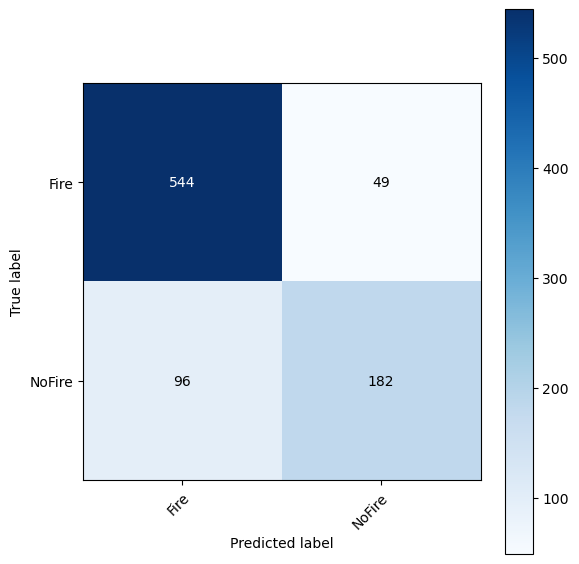

In [27]:
#Plotting the confusion matrix
confusion_mtx = confusion_matrix(actual_labels, predicted_labels)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(actual_labels, predicted_labels, Classes = CATEGORIES)

### Normalized

None


<Axes: xlabel='Predicted label', ylabel='True label'>

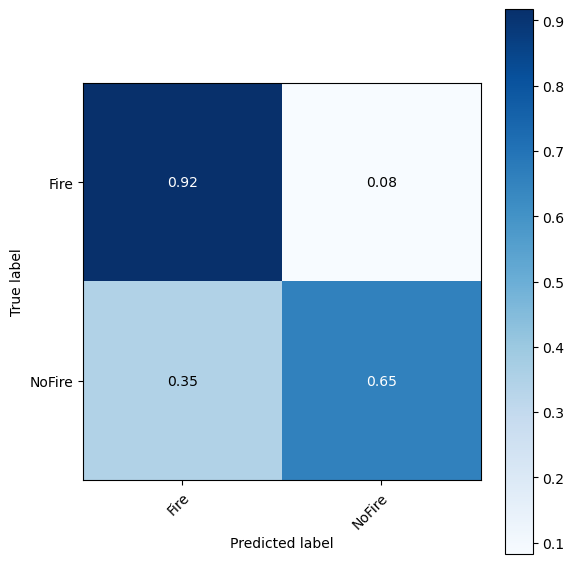

In [28]:
plot_confusion_matrix(actual_labels, predicted_labels, Classes = CATEGORIES, normalize = True)

## Performance Matrics

In [29]:
get_metrics(actual_labels, predicted_labels)

display_classification_report(actual_labels, predicted_labels, CATEGORIES)

Accuracy: 0.8335
Precision: 0.8302
Recall: 0.8335
F1 Score: 0.829

Report:
              precision    recall  f1-score   support

        Fire       0.85      0.92      0.88       593
      NoFire       0.79      0.65      0.72       278

    accuracy                           0.83       871
   macro avg       0.82      0.79      0.80       871
weighted avg       0.83      0.83      0.83       871



## ROC Curve

In [30]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predicted_labels)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.7860227837965715

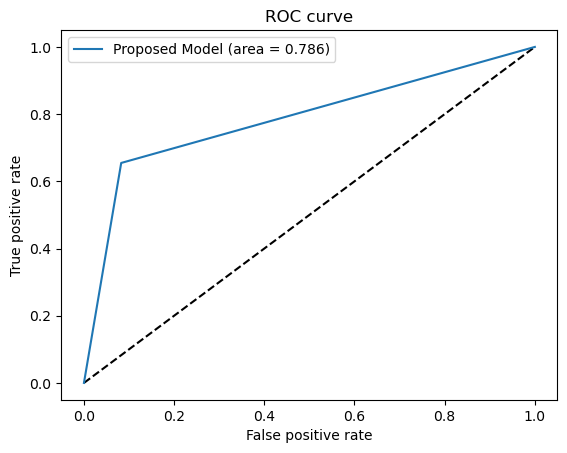

In [32]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Proposed Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

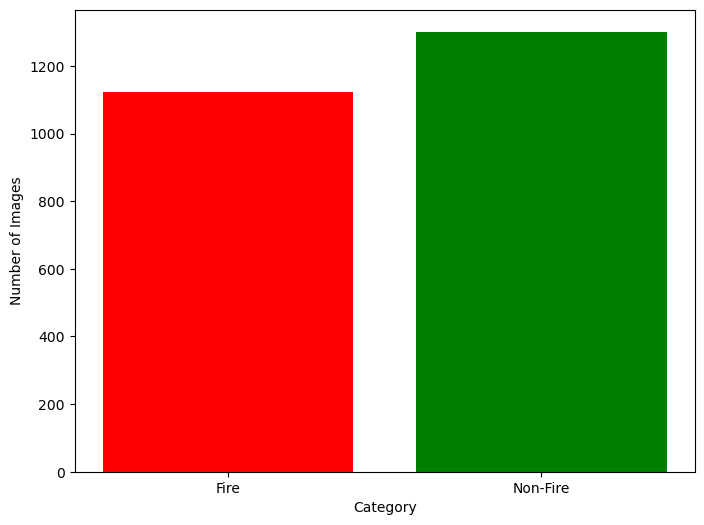

In [2]:
import matplotlib.pyplot as plt

# Data for the bar chart
categories = ['Fire', 'Non-Fire']
values = [1124, 1301]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['red', 'green'])
plt.xlabel('Category')
plt.ylabel('Number of Images')
# plt.title('Number of Fire and Non-Fire Images')
plt.show()
